# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

An HR company want to provide a professional advice on salary for its customers. It turns out to be very a valuable information for both the candidates, that are not sure how much money they should aim for in negotiation process and for companies that don't want to offer too low salary for an open position, which could discaurage talented candidates, but on the other hand they don't want to overpay them, as unnecessarily high salaries mean smaller budget for other companies expenses.

The company is currently using a simple model, which is average salary per industry and job type, but is looking for a more accurate solution, as suggesting too low or too high salary for a job position is leading to either not satisfied employees leaving their employer or not satisfied companies, that eventually finds out that they are paying too much. Result of both cases is negative review of the HR company, which logically leads to less customers.

The final product is expected to be a machine learning model delivered in a form, in which it can both easily used to predict new salaries but also can be easily maintained and retrained as the labour market changes and new data becomes available.

In [33]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from salary_predictions_helper import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# author info
__author__ = "Ivana Hybenova"
__email__ = "ivana.hybenova1@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#loading the data into a Pandas dataframe
train_features = pd.read_csv('train_features.csv')
display(train_features.head())
print(train_features.shape)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


(1000000, 8)


In [3]:
train_features.jobType.unique()

array(['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR',
       'CTO', 'SENIOR'], dtype=object)

In [4]:
train_salaries = pd.read_csv('train_salaries.csv')
display(train_salaries.head())
print(train_salaries.shape)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


(1000000, 2)


In [5]:
data = pd.merge(train_features, train_salaries, left_on = 'jobId', right_on = 'jobId')
display(data.head())
print(data.shape)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


(1000000, 9)


### ---- 3 Clean the data ----

Goal of this section is to identify possible issues with current and future data used for model training.
It is important to make sure, that all invalid data are captured and handled in the final pipeline.

#### 3a. Looking for  invalid data 

In [6]:
# making sure each column has expected datatype
data.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [7]:
# Duplicated rows
print('Number of duplicate rows = %d' % (data.duplicated().sum()))

Number of duplicate rows = 0


In [8]:
# Negative yearsExperience
negative_yearsExperience = data[data['yearsExperience'] < 0].copy()
# negative_yearsExperience
print("JobIds with negative amount of years of experience: ") 
display(negative_yearsExperience)


JobIds with negative amount of years of experience: 


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [9]:
# Negative milesFromMetropolis
negative_milesFromMetropolis = data[data['milesFromMetropolis'] < 0].copy()
# negative_yearsExperience
print("JobIds with negative amount of miles from metropolis: ") 
display(negative_milesFromMetropolis)

JobIds with negative amount of miles from metropolis: 


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [10]:
# Negative or 0 salary
invalid_salary = data[data['salary'] <= 0].copy()
# negative_yearsExperience
print("JobIds with negative or zero value for Salary: ") 
display(invalid_salary)
# dropping rows with 0 salary
data = data[~data['jobId'].isin(list(invalid_salary['jobId']))]

JobIds with negative or zero value for Salary: 


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


3b. Looking for missing data

In [11]:
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

	jobId: 0
	companyId: 0
	jobType: 0
	degree: 0
	major: 0
	industry: 0
	yearsExperience: 0
	milesFromMetropolis: 0
	salary: 0


In [12]:
# show rows with missing values
data[(data['yearsExperience'].isnull()) | (data['milesFromMetropolis'].isnull())]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [13]:
data[data['jobType'] == 'JANITOR'].shape

(124971, 9)

In [14]:
# dropping row with missing values
data.drop(data[(data['yearsExperience'].isnull()) | (data['milesFromMetropolis'].isnull())].index, axis = 0, inplace = True)

##### Notes for automated preprocessing:
1. Make sure that all used numerical features don't have negative values
2. Make sure that each new datapoint for retraining the model has positive salary value

### ---- 4 Explore the data (EDA) ----

In [15]:
# dropping 'jobId' and 'companyId' column from the data
data.drop(['jobId'], axis = 1, inplace = True)
data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [16]:
data.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


##### 4.a) Exploration of target variable

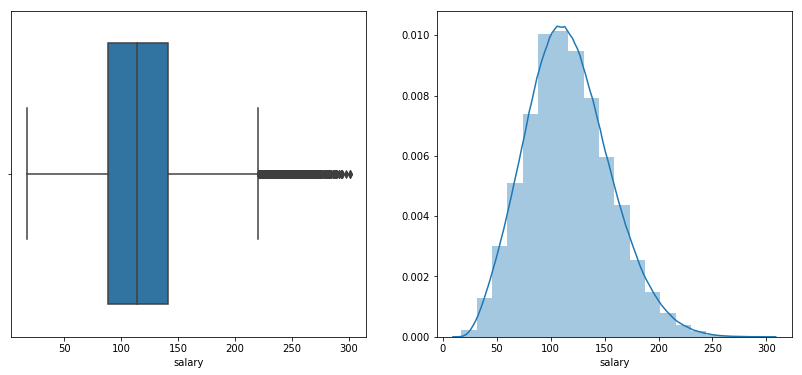

In [17]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(data.salary)
plt.subplot(1,2,2)
sns.distplot(data.salary, bins=20)
plt.show()

In [18]:
print(plt.figure)

<function figure at 0x00000256BCFF4950>


Examination of outliers

In [19]:
# Computation of IQR
stat = data.salary.describe()
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [20]:
#check potential outlier above upper bound
data.loc[data.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

In [21]:
# Check most suspicious potential outliers above upper bound
data[(data.salary > 222.5) & (data.jobType == 'JUNIOR')]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


##### 4.b) Exploration of numerical variables and relationship with the target

In [22]:
### Numerical variables
numeric_vars = [var for var in data.columns if data[var].dtypes!='O']
numeric_vars.remove('salary')
print('Numerical variables: ', numeric_vars)


Numerical variables:  ['yearsExperience', 'milesFromMetropolis']


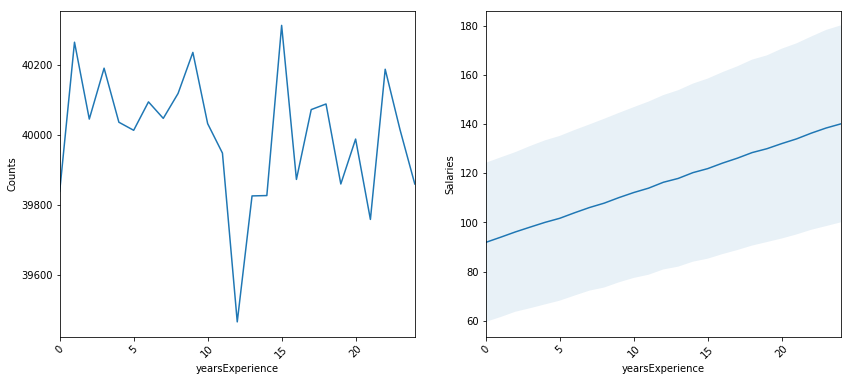

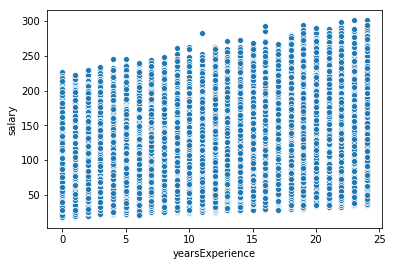

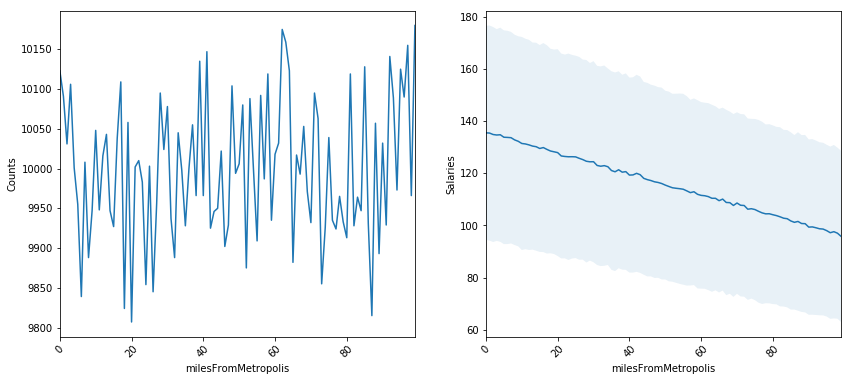

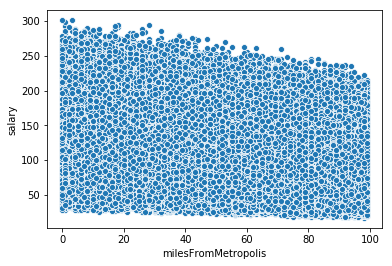

In [23]:
for var in numeric_vars:
    plot_feature(data, var)

##### 4.c) Exploration of categorical variables and relationship with the target

In [24]:
data.dtypes

companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [25]:
### Categorical variables
cat_vars = [var for var in data.columns if data[var].dtypes=='O']
summarize_cat_vars(data, cat_vars)

Number of categorical variables:  5

companyId 63  categories
jobType 8  categories
['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']

degree 5  categories
['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']

major 9  categories
['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']

industry 7  categories
['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


There are no rare labels in companyId
There are no rare labels in jobType
There are no rare labels in degree
There are no rare labels in major
There are no rare labels in industry


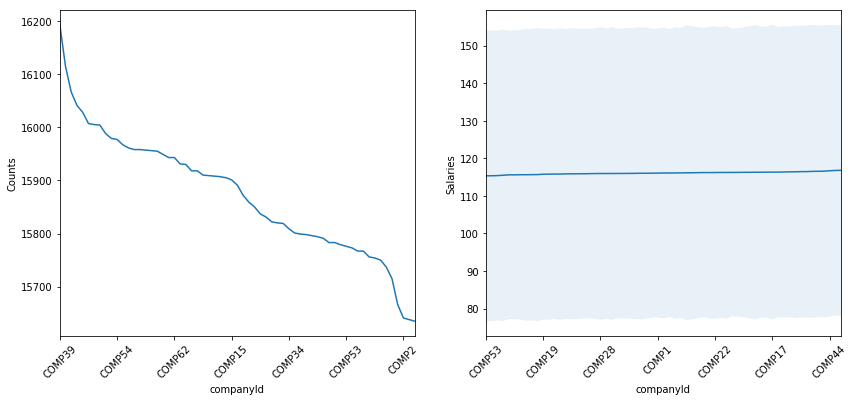

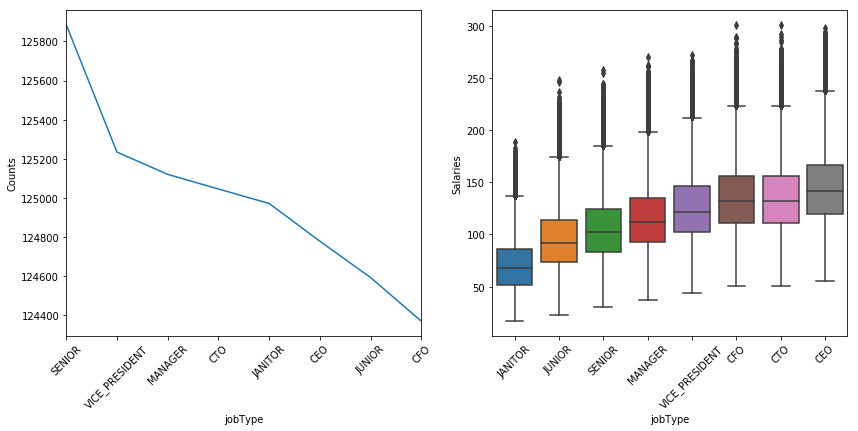

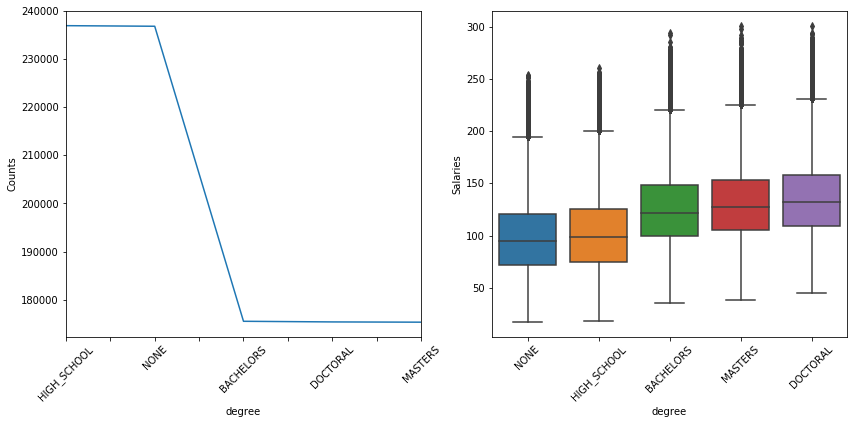

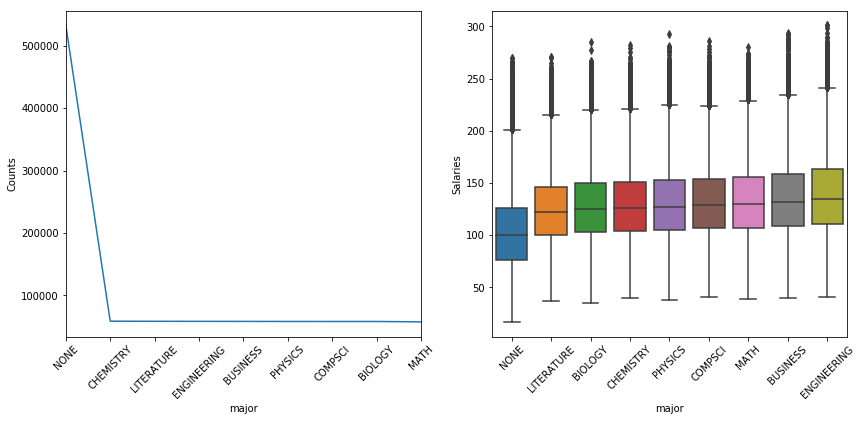

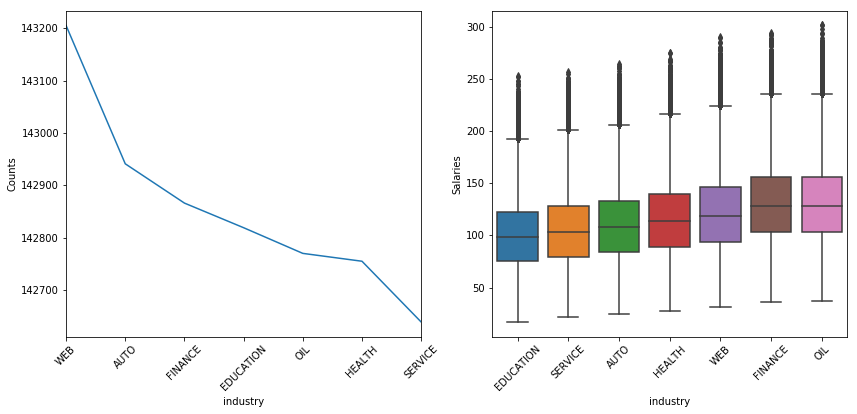

In [26]:
for var in cat_vars:
    plot_feature(data, var)

##### 4.d) Exploring relations between variables

In order to construct the heatmap in case of categorical variables the mean salary for each category will be used

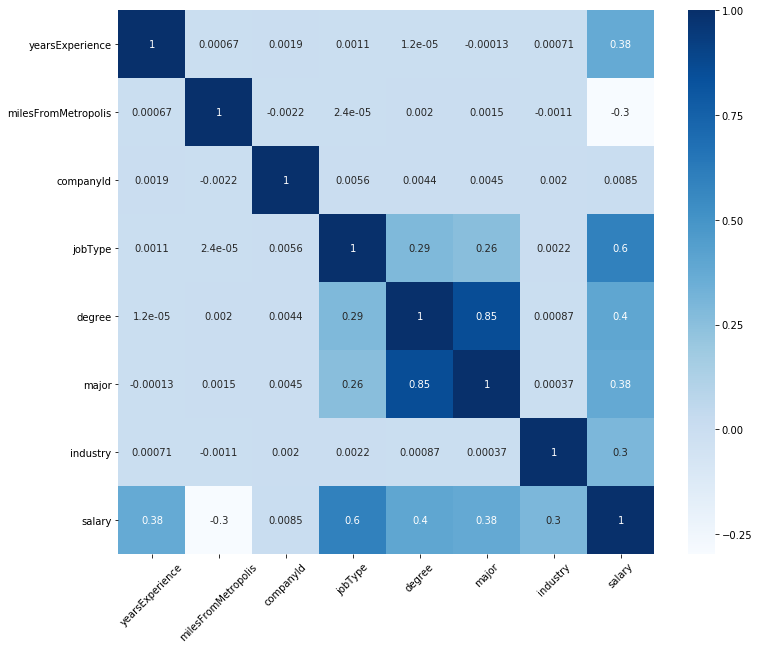

In [27]:
plot_heatmap(data, numeric_vars, cat_vars)

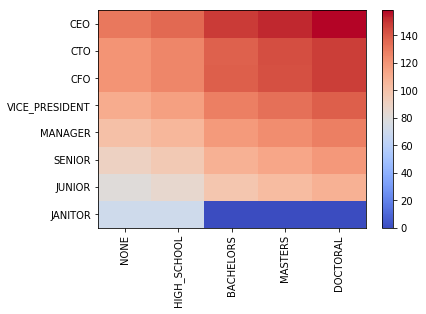

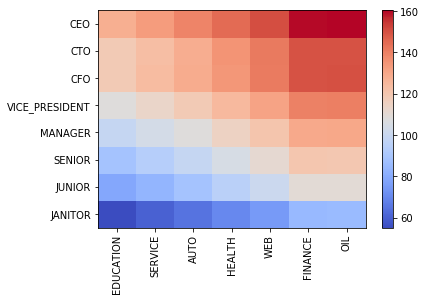

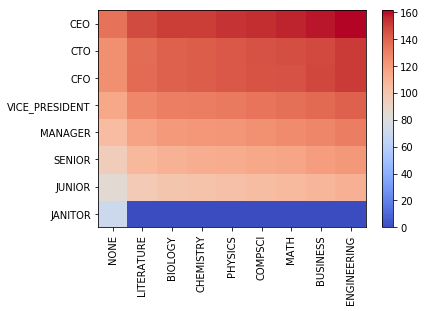

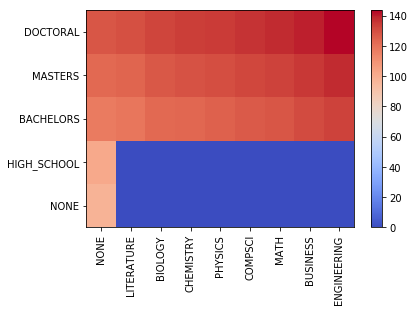

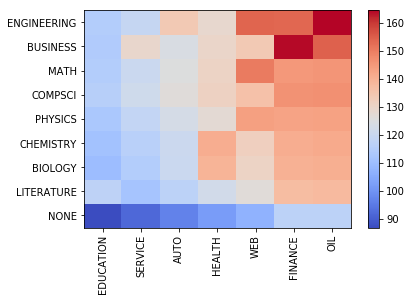

In [28]:
combinations = [['jobType', 'degree'],['jobType', 'industry'], ['jobType', 'major'], ['degree', 'major'], ['major', 'industry']]
for combo in combinations:
    plot_categorical_heatmap(data, combo[0], combo[1])

Note for feature generation:   
    Best combinations: OIL + ENGINEERING, FINANCE + BUSINESS, CEO + ENGINEERING, DOCTORAL + ENGINEERING, CEO + DOCTORAL, JANITOR + OIL  
    Worst combinations: JANITOR + EDUCATION, 

Notes for feature selection:
All variables are correlated.

### ---- 5 Establish a baseline ----

In [37]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation
X_train, X_test, y_train, y_test = train_test_split(data.drop(['salary'], axis = 1), data['salary'], 
                                                    test_size=0.2, 
                                                    random_state=1234)
base_reg = base_regressor()
base_reg.fit(X_train, y_train)
y_test_pred = base_reg.predict(X_test)

For each case was mean salary of given combination of jobType, degree and industry found.


In [38]:
base_mse = mean_squared_error(y_test, y_test_pred)
base_mae = mean_absolute_error(y_test, y_test_pred)
print('MSE of the base model: ' + str(base_mse))
print('MAE of the base model: ' + str(base_mae))

MSE of the base model: 742.7498175743413
MAE of the base model: 21.70608204117416


### ---- 6 Hypothesize solution ----

The base model predicts salary based on average salary of given job type, degree and industry.  
The new model needs to take into account also miles from metropolis and years of experience.  
Even though relationship between each of this numerical features and salary is linear,   
I would rather go for algorithms that can model also non linear relationships such as tree-based models: Decision Trees, Random Forest and Gradient Boosted Trees.  
The challenge is not in feature selection in this case, but in generating new features, to help the algorithms see the patterns among categories,  
For this I will use summary statistics of each group, where groups will be created by jobType, degree and industry.  
CompanyID will be dropped as it doesn't imply and relationship with the target variable, and the model will be thisway generalized towards any company.  